In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [299]:
clean_df = pd.read_csv("clean_df.csv")

clean_df

,Unnamed: 0,Date,Stock,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,shares_outstanding,price
0,10800,2006-07-31,Stock 73,-0.399639,-0.876965,-0.877396,-0.965936,-0.852046,0.859844,-1.813762,-0.487511,1.439440
1,10801,2006-08-31,Stock 73,-1.004340,-0.651984,-1.151288,-1.380792,-1.487287,0.764524,0.125508,-0.720229,1.238517
2,10802,2006-09-29,Stock 73,0.219702,-1.665103,-0.975541,-0.140407,-0.005777,-0.174518,0.217679,0.198414,1.190744
3,10803,2006-10-31,Stock 73,0.112602,1.282577,0.950275,1.512800,0.894990,-0.395854,0.940681,-1.602063,1.175588
4,10804,2006-11-30,Stock 73,1.859252,-0.950435,0.666479,0.980668,1.045786,-1.254375,-0.195889,0.424481,1.257795
...,...,...,...,...,...,...,...,...,...,...,...,...
145,10945,2018-08-31,Stock 73,0.482245,1.085785,1.077461,1.101595,0.325458,0.953941,-1.575137,-1.593163,-0.900711
146,10946,2018-09-28,Stock 73,1.130705,0.733119,1.295533,-0.478905,0.014457,0.811975,-0.556046,0.122189,-0.968820
147,10947,2018-10-31,Stock 73,0.143905,1.758481,1.295484,1.430163,1.213920,0.120901,1.110056,1.315183,-1.042433
148,10948,2018-11-30,Stock 73,-0.906232,0.928734,-0.008811,0.830866,0.201674,-0.700954,1.029783,0.957957,-1.002607


Let's see how the LinearRegression does on the first try.

In [300]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = clean_df["price"]

X = clean_df[["liabilities","equity","total_assets","current_assets","total_revenue","net_income","shares_outstanding"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

lrm = linear_model.LinearRegression()

lrm.fit(X_train, y_train)

LinearRegression()

So that's not the accuracy I want, let's see if there is anything we can do to fix it.

In [301]:
accuracy_score = lrm.score(X_test, y_test)
accuracy_score

-0.14398823805374228

Let's see if a heatmap can tell us anything about the variables being correlated to the price.

<Axes: >

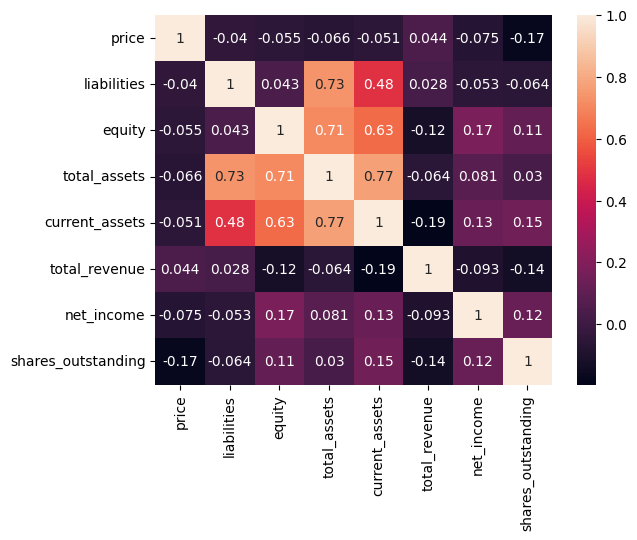

In [302]:
sns.heatmap(clean_df[["price","liabilities","equity","total_assets","current_assets","total_revenue","net_income","shares_outstanding"]].corr(),annot=True)

Unfortunately, it looks like the price is pretty independent of each individual variable. There are some correlations between liabilities, total_assets, current_assets, and equity but this doesn't help us predict the price.

So, let's try a different model, after doing some research, SVR or Support Vector Regression seemed to be pretty popular for regressing Time Series data, so let's see if that helps.

In [303]:
from sklearn.svm import SVR

svr = SVR()

X = clean_df[["liabilities","equity","total_assets","current_assets","current_liabilities","total_revenue","net_income","shares_outstanding"]].sample(frac=0.3, replace=True)
y = clean_df.price.sample(frac=0.3, replace=True)

svr.fit(X,y)

svr.score(X,y) # ok it's better than linear regression, but there are a few values we can tweak to help it out

0.4402405953517664

Let's add some parameters to fine tune the Support Vector Machine a little bit. Gamma, C, and epsilon all impact how each point affects the regression, I explain it more in the presentation.

In [304]:
svr1 = SVR(kernel='rbf',gamma=0.5, C=20, epsilon = 0.02)

X = clean_df[["liabilities","equity","total_assets","current_assets","current_liabilities","total_revenue","net_income","shares_outstanding"]].sample(frac=0.3, replace=True)
y = clean_df['price'].sample(frac=0.3, replace=True, axis = None)

svr1.fit(X,y)

svr1.score(X,y) # significant improvement! now let's shape the data by differencing it, hopefully eliminating trend and seasonality so we have a better regression

0.7051278624676703

In [305]:
clean_df["total_revenue"] = clean_df["total_revenue"].diff()
clean_df["liabilities"] = clean_df["liabilities"].diff()
clean_df["equity"] = clean_df["equity"].diff()
clean_df["total_assets"] = clean_df["total_revenue"].diff()
clean_df["current_assets"] = clean_df["current_assets"].diff()
clean_df["current_liabilities"] = clean_df["current_liabilities"].diff()
clean_df["net_income"] = clean_df["net_income"].diff()
clean_df["shares_outstanding"] = clean_df["shares_outstanding"].diff()

In [306]:
clean_df = clean_df.dropna() # differencing leaves one data point NA because it takes the first difference of each data point and replaces it

clean_df

,Unnamed: 0,Date,Stock,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,shares_outstanding,price
2,10802,2006-09-29,Stock 73,1.224042,-1.013119,-0.843721,1.240385,1.481510,-0.939042,0.092170,0.918643,1.190744
3,10803,2006-10-31,Stock 73,-0.107100,2.947680,0.717706,1.653207,0.900767,-0.221336,0.723003,-1.800478,1.175588
4,10804,2006-11-30,Stock 73,1.746649,-2.233012,-0.637186,-0.532132,0.150796,-0.858522,-1.136571,2.026544,1.257795
5,10805,2006-12-29,Stock 73,-0.722228,2.720204,2.288901,-1.120580,-1.171702,1.430379,0.026224,-1.657515,1.210560
6,10806,2007-01-31,Stock 73,-1.421667,-2.202252,-1.193190,-0.484848,-0.610298,0.237188,0.276459,-0.154438,1.161338
...,...,...,...,...,...,...,...,...,...,...,...,...
145,10945,2018-08-31,Stock 73,0.229924,0.864573,-1.022911,-0.388959,-0.653483,-0.546468,-0.401214,-0.603017,-0.900711
146,10946,2018-09-28,Stock 73,0.648460,-0.352666,0.404502,-1.580500,-0.311001,-0.141967,1.019092,1.715352,-0.968820
147,10947,2018-10-31,Stock 73,-0.986800,1.025361,-0.549107,1.909068,1.199464,-0.691073,1.666101,1.192994,-1.042433
148,10948,2018-11-30,Stock 73,-1.050137,-0.829747,-0.130782,-0.599297,-1.012246,-0.821856,-0.080273,-0.357226,-1.002607


Time to retry our regressions!

In [307]:
y = clean_df["price"]

X = clean_df[["liabilities","equity","total_assets","current_assets","current_liabilities","total_revenue","net_income","shares_outstanding"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

lrm = linear_model.LinearRegression()

lrm.fit(X_train, y_train)

LinearRegression()

In [308]:
accuracy_score = lrm.score(X_test, y_test)
accuracy_score # still terrible, I don't think LinearRegression was made for this

-0.18490207175118667

So differencing didn't really help with the linear regression, how about SVR?

In [311]:
svr1.fit(X,y)

svr1.score(X,y) # Bang! It doesn't get much better than that

0.9995955160783419